**Dataset:**
personality type data (Lab 2 - Personality Profile Type.csv)

**Objective:**
classify Personality type as one of the following **using RNNs**. <br>
['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

**Evaluation metric:**
Precision

### Import used libraries

In [99]:
import pandas as pd
import numpy as np
import tensorflow as tf
import spacy
import re
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


### Load Dataset

In [100]:
df = pd.read_csv("Lab 2 - Personality Profile Type.csv")
df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin* That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes. Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your o..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub, Long time no see. Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. Just go on permanent vacation.|||Two months? I wouldn't be crazy about the idea. If you are really hi...
5,INTJ,"'18/37 @.@|||Science is not perfect. No scientist claims that it is, or that scientific information will not be revised as we discover new things. Rational thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party star..."
6,INFJ,"'No, I can't draw on my own nails (haha). Those were done by professionals on my nails. And yes, those are all gel. You mean those you posted were done by yourself on your own nails? Awesome!|||Probably the Electronic Screen Syndrome. With the advent of technology and social media, we all suffer from overstimulation on a daily basis. I'm guilty as well. In the past, I can be happy just...|||I love nail arts too! These are some of mine: 718282 718290 718298 718306 718314|||This is the first..."
7,INTJ,"'I tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called 'Everything' from there it get sorted into type and sub type|||i ike to collect odd objects, even at work...a lot of people would call it junk but i like to collect it. Old unused software? ill take that off your hands :) i have a bunch of old adobe...|||i think its quite normal, i tend to only see my friends in real life every c

### Data splitting

In [101]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train=df.iloc[0:int(len(df)*0.8),:]
df_test=df.iloc[int(len(df)*0.8):,:]

In [102]:
print("df_train",df_train.shape)
print("df_test",df_test.shape)

df_train (6940, 2)
df_test (1735, 2)


### EDA on training data

- check NaNs

In [103]:
df_train.isna().sum()

type     0
posts    0
dtype: int64

- check duplicates

In [104]:
duplicate_rows = df_train[df_train["posts"].duplicated()]
print(len(duplicate_rows))

0


- show a representative sample of data texts to find out required preprocessing steps

In [105]:
df_train.head(20)

,type,posts
0,INTP,"'This. When I lie it's to avoid an unreasonable response for something I did that was completely justifiable to me but if I was to try to justify to someone else they'd be too hung up on what I did. I...|||Your IQ (SD15): 128|||I typically have very difficult times maintaining friends I've come to realize. I've had people I talk to for years and I still don't want to talk to them... I DID, but then I just got bored of them,...|||An INTJ friend of mine told me she really hates eating because ..."
1,INTJ,"'I said zero flexibility and little time for dating. Going around sifting through dates to find one that clicks isn't going to be as viable. That has nothing to do with maintaining a relationship I...|||How you've come to the conclusion I have nothing to offer merely because I am busy is beyond me. No not really. Again, more made up stuff.|||okay, this isn't cool. you're specifically looking to get into a relationship because you're about to enter a life phase where you will not hav..."
2,INTP,"'This has to be written with bias or something, I'm not sure how you could even say that truthfully. For some reason you put subjectivity for both God and man? It says nothing. That makes no...|||??? How? The main priority of the church is written throughout it's texts for the past nearly 2000 years and reverberated throughout the church's dialogues both before and after the incident about...|||That's an annoying phrasing, as it's just obtuse and confusing to newcomers. I don't blame you..."
3,ENFP,"'HAuhuHAuh You might be right Muhicz. I'm just wondering if these steps come exactly the same ages like it said, it's tought to believe scientifically... but, it doesn't really matter, the point is...|||Thank you, MisterJordan. Your words are helpfull. It helps me to think that the conflicting beetwen Fi and Ti could be an inner development of myself, improving who I am. But I must say I'm not the...|||I've read about the Fe and Fi functions, I'm a Fi. I also know well about the MBTI types, ..."
4,ENTJ,"'Her parents are kind of the go to college = good job people, and they want her to have a stable career. She on the other hand, wants to travel, perhaps teach English in foreign lands (especially in...|||I have a friend who is going through this crisis. She is about to graduate high school, and has absolutely know idea what to do with her life. She doesn't have anything she's really passionate...|||I recently met a few waitresses at one restaurant in my town who served for a living. I know..."
5,INFJ,"'that's so ironic, considering how your signature is cats are the better people.. cats are known to kill or play with their prey for fun. you think that's wrong because that's how you were...|||ooh, I'm a virgo rising INFJ! virgo is also one of my fav zodiac signs. INFJ's is that kind and honest childhood friend who even after years of not talking would be happy to check up on you and...|||I'm consumed by machiavellianism in dark periods of my life. I sometimes just get fed up by all the fa..."
6,INTJ,"'Well said , Codger.|||You will like it. :proud:|||Never mind. Apologies for the intrusion.|||True. Hey Cetanu. Been a while. How ya doin ?|||Hey ChancyRose, how are ya ? Add me to that list too. The punching bag thing didn't really work...|||I've got mine on; and the world is still retarded....among other things.|||Good luck.|||u200b Good morning people..|||Anyway... Nothing to do but go to bed and deal with whatever bullshit my subconscious has in store for me. At least it would be a chan..."
7,ENTP,"'Just curious. I realise this is a bit of a stupid question, and bound to generalisations, but would there be anything the way NFs look, dress etc which is distinguishable from others?|||I can relate to this so much it's ridiculous|||Nothing goes unnoticed.|||I 'deal' with loneliness by: - Rationalising and shooing it away (only works less than half of the time) - Focusing on my main current goal (successfully used loneliness as a

- check dataset balancing

<Axes: xlabel='type'>

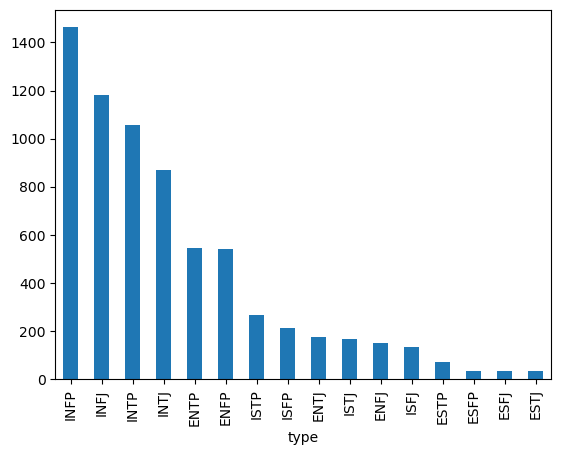

In [106]:
df_train["type"].value_counts().plot(kind="bar")

- Cleaning and Preprocessing are:
    - 1
    - 2
    - 3
    - ... etc.

### Cleaning and Preprocessing

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
        # Add any initialization code here
    
    def fit(self, X, y=None):
        # Add code for fitting the transformer here
        return X
    def clean_text(self,text):
        #return text
        # Remove emojis
        
        text_without_links = re.sub(r"https?://\S+", "", text) # remove urls 
        text = re.sub(r'[\U00010000-\U0010ffff]', '', text) # remove emojji
        clean_string = re.sub(r'[^a-zA-Z\s]', '', text) #remove non word characters 
        return clean_string
        
    
    def transform(self, X):
        # Add code for transforming the data here
        transformed_X = X.copy()  # Example: Just copying the data
        
        # Example transformation
        transformed_X['posts'] = transformed_X['posts'].str.lower().str.strip()
        transformed_X['posts'] = transformed_X['posts'].apply(self.clean_text)
        
        # Do all the needed transformations and data preprocessing here
        #print("values",transformed_X["tweet"].values)
        return transformed_X["posts"].values
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        self.fit(X, y)
        return self.transform(X)

In [108]:
df_trained_preprocessed=CustomTransformer().transform(df_train)
df_test_preprocessed=CustomTransformer().transform(df_test)

In [109]:
# showing data after preprocessing 
df_trained_preprocessed

array(['this when i lie its to avoid an unreasonable response for something i did that was completely justifiable to me but if i was to try to justify to someone else theyd be too hung up on what i did iyour iq sd i typically have very difficult times maintaining friends ive come to realize ive had people i talk to for years and i still dont want to talk to them i did but then i just got bored of theman intj friend of mine told me she really hates eating because its so repetitive as an intp i dont really feel bothered i dont really register eating i just do it while im thinking aboutsimilar minds advanced testintp  sxso i have a lot of friends but i only have one i speak about how i actually feel with and only  other that i talk about what i am actually thinking about  with regards togetting close to someone and end up wanting to be infinitely close to them and end up merging every damn timeinteresting topic i know two enfps  is strange as an intp i view some of the stuff she does as c

In [110]:
X_train, X_test, y_train, y_test = df_trained_preprocessed,df_test_preprocessed,df_train["type"].values,df_test["type"].values

In [111]:
#### choose max_sequence_len

In [112]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)

In [113]:
len(train_sequences)

6940

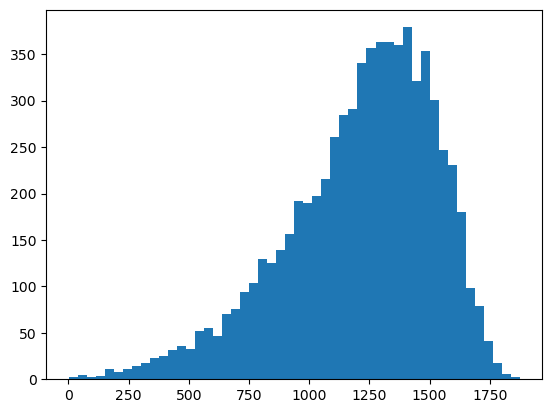

In [114]:
plt.hist([len(s) for s in train_sequences], bins=50)
plt.show()

In [115]:
## padding train data 
x_train_padded = pad_sequences(train_sequences, maxlen=1750, padding='post')
x_train_padded.shape

(6940, 1750)

In [116]:
### transform data 
new_sequences = tokenizer.texts_to_sequences(X_test)
x_test_padded = pad_sequences(new_sequences, maxlen=1750, padding='post')
x_test_padded.shape

(1735, 1750)

**You  are doing Great so far!**

### Modelling

In [152]:
VOCAB_SIZE = len(tokenizer.word_index)+1
VOCAB_SIZE

281060

In [153]:
y_test

array(['ENTP', 'ENFJ', 'ISTP', ..., 'INFJ', 'INFP', 'INTJ'], dtype=object)

In [154]:
### encode labels 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_train_encoded = tf.keras.utils.to_categorical(y_encoded)
y_test_encoded =tf.keras.utils.to_categorical( label_encoder.transform(y_test))

y_train_encoded.shape

(6940, 16)

In [155]:

model = tf.keras.models.Sequential([    
    tf.keras.layers.Embedding(VOCAB_SIZE, 128),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

In [156]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy', tf.keras.metrics.Precision()])

In [157]:

print(x_train_padded.shape)
print(y_train_encoded.shape)

print(x_test_padded.shape)
print(y_test_encoded.shape)

(6940, 1750)
(6940, 16)
(1735, 1750)
(1735, 16)


In [158]:
history = model.fit(x_train_padded, y_train_encoded, epochs=5, batch_size=128,
                    validation_data=(x_test_padded, y_test_encoded), 
                    validation_steps=30)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1604 - loss: 2.4365 - precision_6: 0.0000e+00

C:\anac\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 415s 7s/step - accuracy: 0.1609 - loss: 2.4347 - precision_6: 0.0000e+00 - val_accuracy: 0.1424 - val_loss: 2.2995 - val_precision_6: 0.0000e+00
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.1847 - loss: 2.2978 - precision_6: 0.0000e+00 - val_accuracy: 0.2133 - val_loss: 2.3001 - val_precision_6: 0.0000e+00
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.1994 - loss: 2.2802 - precision_6: 0.0000e+00 - val_accuracy: 0.1671 - val_loss: 2.2970 - val_precision_6: 0.0000e+00
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.1998 - loss: 2.2959 - precision_6: 0.0000e+00 - val_accuracy: 0.2127 - val_loss: 2.3049 - val_precision_6: 0.0000e+00
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.2138 - loss: 2.2897 - precision_6: 0.0000e+00 - val_accuracy: 0.2127 - val_loss: 2.2986 - val_precision_6: 0.0000e+00


#### Evaluation

**Evaluation metric:**
Precision

In [160]:
test_loss, test_acc = model.evaluate(x_test_padded, y_test_encoded)
print(test_loss)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 273ms/step - accuracy: 0.2013 - loss: 2.3165 - precision_6: 0.0000e+00


ValueError: too many values to unpack (expected 2)

In [161]:
model.evaluate(x_test_padded, y_test_encoded)

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.2013 - loss: 2.3165 - precision_6: 0.0000e+00


[2.298593044281006, 0.21268011629581451, 0.0]

### Enhancement

### Conclusion and final results


#### Done!